In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from pprint import pprint
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, inspect

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [5]:
inspector.get_table_names()

['measurement', 'station']

In [6]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
session = Session(engine)

In [8]:
Measurement_Columns=inspector.get_columns('measurement')

for columns in Measurement_Columns:
    print(columns['name'])

id
station
date
prcp
tobs


In [9]:
Station_Columns=inspector.get_columns('station')

for columns in Station_Columns:
    print(columns['name'])

id
station
name
latitude
longitude
elevation


In [10]:
last=session.query(Measurement).order_by(Measurement.date.desc()).limit(1).all()
last_date= " " 

for info in last:
    last_date=info

print(last_date.date)

2017-08-23


In [11]:
first_day=dt.date(2017,8,23)-dt.timedelta(days=365)

In [12]:
results=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>= first_day).all()

In [13]:
percip_df=pd.DataFrame(results, columns=['date', 'percipitation'])
percip_df.set_index(['date'], inplace=True)
final_df= percip_df.sort_values('date')
final_df.head(0)

,percipitation
date,


C:\Users\abroc\anaconda\Anaconda3\envs\PyData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


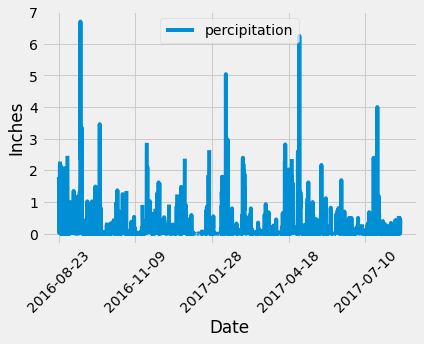

In [14]:
final_df.plot(rot=45)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.show()

In [15]:
final_df.describe()

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
station_count=session.query(func.count(Station.id)).all()

print(f'There is a total of {station_count[0][0]} stations')

There is a total of 9 stations


In [17]:
active_stations = (
    session.query(Measurement.station, Station.name, func.count(Measurement.id))
    .filter(Measurement.station == Station.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
    .all()
)
print("Most active stations are:")
pprint(active_stations)

Most active stations are:
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [18]:
station_record = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == active_stations[0][0])
    .all()
)

print(
    f"Most active station is {active_stations[0][0]} - {active_stations[0][1]}. Following are its records:"
)
print(f"Highest Temperature: {station_record[0][1]}F")
print(f"Lowest Temperature: {station_record[0][0]}F")
print(f"Average Temperature: {station_record[0][2]}F")

Most active station is USC00519281 - WAIHEE 837.5, HI US. Following are its records:
Highest Temperature: 85.0F
Lowest Temperature: 54.0F
Average Temperature: 71.66378066378067F


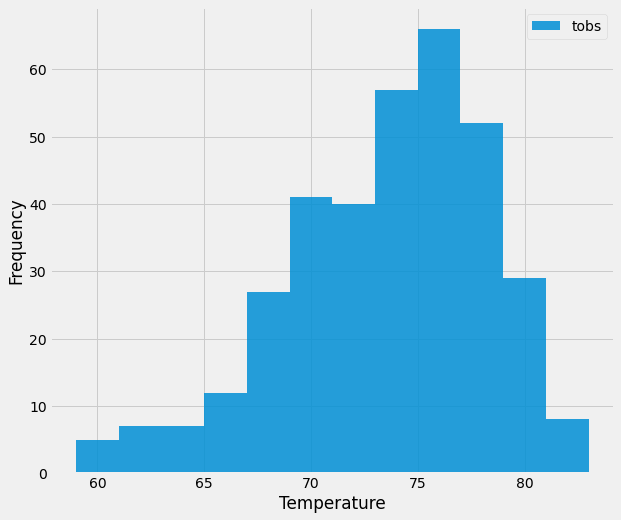

In [19]:
temp_results = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date > first_day)
    .filter(Measurement.station == active_stations[0][0])
    .order_by(Measurement.date)
    .all()
)

temp_df = pd.DataFrame(temp_results)
temp_df = temp_df.set_index("date").sort_index(ascending=True)

temp_df.plot(kind="hist", bins=12, alpha=0.85, figsize=(9, 8))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [20]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
trip_dates = "2017-12-05 to 2017-12-13"
prev_year = "2016-12-05 - \n 2016-12-13"

prev_year_start = dt.date(2017, 12, 5) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 12, 13) - dt.timedelta(days=365)

temps = calc_temps(prev_year_start, prev_year_end)
temp_min, temp_avg, temp_max = temps[0]

print(f" Min Temp : {temp_min}F")
print(f" Avg Temp : {temp_avg}F")
print(f" Max Temp : {temp_max}F")

 Min Temp : 65.0F
 Avg Temp : 69.98275862068965F
 Max Temp : 78.0F


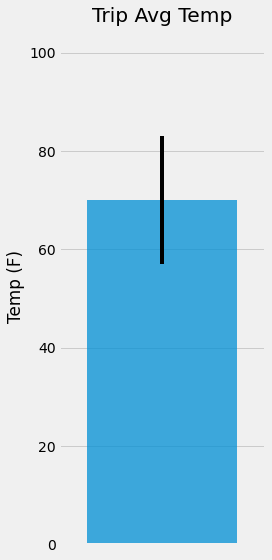

In [22]:
error = temp_max - temp_min
xpos = 1

plt.figure(figsize=(4, 8))
plt.bar(xpos, temp_avg, yerr=error, alpha=0.75,)
plt.title(f"Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.yticks(np.arange(0, 120, 20))
plt.tight_layout()
plt.xlim(0.45, 1.55)
plt.ylim(0, 105)
plt.show()

In [23]:
trip_start = "2016-12-05"
trip_end = "2016-12-13"

rain_station = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.avg(Measurement.prcp),
    )
    .filter(
        Measurement.station == Station.station,
        Measurement.date.between(trip_start, trip_end),
    )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc())
    .all()
)

rain_df = pd.DataFrame(np.array(rain_station))
rain_df = rain_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Total Precipitation",
    }
)

rain_df

,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,0.26
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.164
2,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.14500000000000002
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.1277777777777778
4,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.1166666666666667
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.10571428571428573
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,0.08666666666666667


In [24]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
trip_startdate = dt.date(2018, 1, 1)
trip_enddate = dt.date(2018, 1, 7)

date_range = pd.date_range(trip_startdate, trip_enddate)

date_list = [d.strftime("%m-%d") for d in date_range]

daily_normal = [daily_normals(d)[0] for d in date_list]
pprint(daily_normal)

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]


In [26]:
normal_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
normal_df.index.name = "Date"
normal_df

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


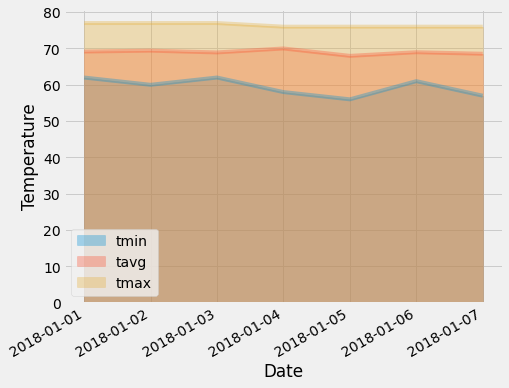

In [27]:
normal_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(7, 6))
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()